# Generating Poetry:

Coursera link: https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/csOxp/looking-into-the-code


Github Notebook Link: https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%204%20-%20Lesson%202%20-%20Notebook.ipynb

In [0]:
import json
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers



2.2.0-rc1


In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2020-03-30 22:17:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0s      

2020-03-30 22:17:58 (141 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [0]:
# data = open('/tmp/irish-lyrics-eof.txt').read()

# print(type(data))
# print(data)


# corpus = data.lower().split("\n")

In [0]:
# # for line in data:
# #   print(line)

# for i in range(0,40,1):
#   print(data[i])

In [0]:
df = pd.read_csv('/tmp/irish-lyrics-eof.txt', sep='\n', header=None, engine='python')

print(df.head())
print(df.shape)



                                         0
0       Come all ye maidens young and fair
1  And you that are blooming in your prime
2  Always beware and keep your garden fair
3         Let no man steal away your thyme
4         For thyme it is a precious thing
(1692, 1)


In [0]:
# # We have to add the line breakers manually so it can generate the poetry!!!
# df.iloc[:,0] = df.iloc[:,0].apply(lambda val : val + ' linebreak')

# print(df.head())
# print(df.shape)

In [0]:
# Converting the pd df into list of strings:
corpus = df.iloc[:,0].astype(str).tolist()

print(type(corpus))

# Creating the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1  # add one for possible oov in the test set!

print(tokenizer.word_index)
print(vocab_size)


<class 'list'>
{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88

In [0]:
# Sequences:
# instead of sequences the sentences only, we sequence each line in a sequence of adding a word each time until we sequence the whole line. then we move onto the next one and repeat.
# Example: [[In, the], [In, the, town], [In, the town, of,]... ]
# This is called: subsentence engrams.
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

print(input_sequences)


# Pad sequences:
max_sequence_len = max(len(x) for x in input_sequences)
print(max_sequence_len)
max_sequence_len = max(map(lambda x : len(x), input_sequences)) # alternative!
print(max_sequence_len)

# For the padding it is important to add the zeros on the left, as we are gonna take the last word integer of each line as labels:
# I'm not sure why it needs np.array.
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre', truncating='pre'))


# Create predictors and label:
# data examples will have as col size the  max sequence length because we have padded them so.
xs, labels = input_sequences[:,0:max_sequence_len-1], input_sequences[:,max_sequence_len-1]

# we one-hot vectorise the labels with the vocabulary size as dimension of the columns:
ys = to_categorical(labels, num_classes=vocab_size)  # tf.keras.utils.to_categorical function

print(len(xs))
print(xs.shape)
print(xs.shape[1])
print(ys.shape)

[[51, 12], [51, 12, 96], [51, 12, 96, 1217], [51, 12, 96, 1217, 48], [51, 12, 96, 1217, 48, 2], [51, 12, 96, 1217, 48, 2, 69], [2, 11], [2, 11, 15], [2, 11, 15, 31], [2, 11, 15, 31, 361], [2, 11, 15, 31, 361, 8], [2, 11, 15, 31, 361, 8, 24], [2, 11, 15, 31, 361, 8, 24, 1218], [272, 798], [272, 798, 2], [272, 798, 2, 204], [272, 798, 2, 204, 24], [272, 798, 2, 204, 24, 579], [272, 798, 2, 204, 24, 579, 69], [118, 35], [118, 35, 119], [118, 35, 119, 799], [118, 35, 119, 799, 56], [118, 35, 119, 799, 56, 24], [118, 35, 119, 799, 56, 24, 184], [10, 184], [10, 184, 25], [10, 184, 25, 23], [10, 184, 25, 23, 5], [10, 184, 25, 23, 5, 580], [10, 184, 25, 23, 5, 580, 456], [2, 184], [2, 184, 800], [2, 184, 800, 12], [2, 184, 800, 12, 801], [2, 184, 800, 12, 801, 4], [2, 184, 800, 12, 801, 4, 7], [2, 184, 800, 12, 801, 4, 7, 235], [1219, 17], [1219, 17, 12], [1219, 17, 12, 75], [1219, 17, 12, 75, 1220], [1219, 17, 12, 75, 1220, 236], [1219, 17, 12, 75, 1220, 236, 17], [1219, 17, 12, 75, 1220, 236

In [0]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

print(xs[6])
print(ys[6])

print(xs[5])
print(ys[5])

8
1
71
6
713
39
1790
1791
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
[0. 0. 0. ... 0. 0. 0.]
[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


In [0]:
# Building the RNN:
model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_len-1))  # input dimension=vocabulary size, output=embedding dimension, input length = pad length (remember we removed one to use it as label)
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=xs.shape[1]))  # input dimension=vocabulary size, output=embedding dimension, input length = pad length (remember we removed one to use it as label)
model.add(Bidirectional(LSTM(150)))
model.add(Dense(vocab_size, activation='softmax'))   # multi-class classification layer has vocabulary size as classes. And so we have to use softmax (because more than 2) instead of sigmoid; and categorical_crossentropy instead of binary

model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy']) # Adam seems to be a good optimizer for NLP!

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 2690)              809690    
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

num_epochs = 100

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.999
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()

history = model.fit(xs, ys, epochs=num_epochs , callbacks=[callback], verbose=1)

Epoch 1/100
377/377 [==============================] - 4s 10ms/step - loss: 6.6278 - accuracy: 0.0748
Epoch 2/100
377/377 [==============================] - 4s 10ms/step - loss: 5.7327 - accuracy: 0.1150
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 4.8408 - accuracy: 0.1704
Epoch 4/100
377/377 [==============================] - 4s 10ms/step - loss: 3.9233 - accuracy: 0.2406
Epoch 5/100
377/377 [==============================] - 4s 10ms/step - loss: 3.0866 - accuracy: 0.3511
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 2.4342 - accuracy: 0.4546
Epoch 7/100
377/377 [==============================] - 4s 10ms/step - loss: 1.9369 - accuracy: 0.5482
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 1.6218 - accuracy: 0.6103
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 1.3884 - accuracy: 0.6617
Epoch 10/100
377/377 [==============================] - 4s 10ms/step - loss: 1.228

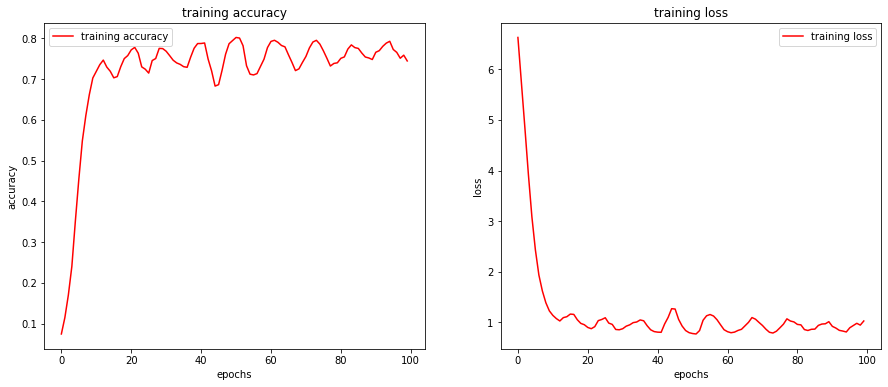

In [0]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']



plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
# plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
# plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training loss')
plt.legend()

plt.show()


# Predicting words:

In [0]:
# Predicting words!

seed_text = 'Help me Obi-Wan Kenobi, you are my only hope'
# seed_text = seed_text + ' linebreak'  # attempt to add linebreaks
next_words = 100  # following 100 words to predict

# token_list = tokenizer.texts_to_sequences([seed_text])[0]
# print(token_list)
# token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre', truncating='pre') 
# print(token_list)

for _ in range(next_words):
  # Sequencing and padding the seed text for the prediction:
  token_list = tokenizer.texts_to_sequences([seed_text]) #[0]  # to sequence it, we have to convert the sentence to a list
  # print(token_list)
  token_list = pad_sequences(token_list, maxlen=max_sequence_len-1, padding='pre', truncating='pre')  # we could use xs.shape[1] as maxlen too

  # Call the trainer prediction:
  # predicted = model.predict_classes(token_list)  # predict_classes is obsolete!
  predicted = np.argmax(model.predict(token_list), axis=-1)  # for multi-class classification using softmax as last layer activation; (model.predict(x)>0.5).astype('int32') for binary classification using sigmoid as last layer activation
  # print(predicted)

  # The predictor gives you the class index (integer) thus then we have to get the corresponding word from the dictionary.

  # Getting the predicted class index to its corresponding word in the dictionary/vocabulary :
  # This is: decoding the predicted class into the word from the dictionary:
  output_word = ''
  for word, index in tokenizer.word_index.items():
    if index==predicted:
      output_word = word
      break
  seed_text += ' ' + output_word  

# printing the result:
print(seed_text)

# # splitting by linebreak:
# seed_text = seed_text.split(' linebreak')
# print(seed_text)



Help me Obi-Wan Kenobi, you are my only hope and ill time their color dare not show one gone alas like our youth too smiling merry are fled and tones that one love light in botany bay what their horror when faded or foot bright day corporal casey by proud old father tom irish eyes gone by and botany sober anger making gone nor mans empty gone mary all your grief are gone by the sorrow that eer i saw of molly white spotted father tom turns each else kept will addle our molly very fright what while springtime gone proud girl is sad when eer you speak of


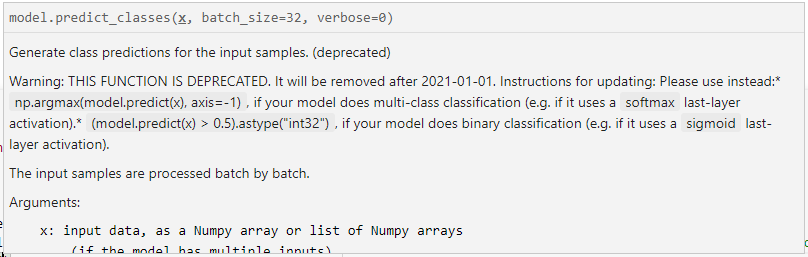